# User study questionnaire  
Mock and plots

Reference: KMunicate - https://bmjopen.bmj.com/content/9/9/e030215


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib as mpl
import statsmodels.api as sm
from scipy.special import expit

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from causallib.estimation import IPW


Generate data

In [3]:
def generate_data(n=1000, seed=0):
    rng = np.random.default_rng(seed)

    # X0, XA, XAY, XA, XAY, XY, XY
    X = rng.normal(0, 0.5, size=(n, 7))
    a_beta = np.array([0, 1, 1, 1, 1, 0, 0])
    a_logit = X @ a_beta
    a_prop = expit(a_logit)
    a = rng.binomial(1, a_prop)

    y_beta = np.array([0, 0, -1, 0, -1, -1, -1])
    effect = 1
    y = X @ y_beta + a * effect + rng.normal(0, 1, size=n)
    
    X = pd.DataFrame(X, columns=["x0", "xa1", "xay1", "xa2", "xay2", "xy1", "xy2"])
    a = pd.Series(a, name="a")
    y = pd.Series(y, name="y")
    return X, a, y

In [4]:
X, a, y = generate_data(seed=0)
X.join(a).join(y)

,x0,xa1,xay1,xa2,xay2,xy1,xy2,a,y
0,0.062865,-0.066052,0.320211,0.052450,-0.267835,0.180798,0.652000,0,-3.260762
1,0.473540,-0.351868,-0.632711,-0.311637,0.020663,-1.162515,-0.109396,0,1.153047
2,-0.622955,-0.366134,-0.272129,-0.158150,0.205815,0.521257,-0.064267,0,0.862789
3,0.683232,-0.332597,0.175755,0.451735,0.047006,-0.371750,-0.460863,1,0.354286
4,-0.228863,0.110098,-0.504809,-0.104588,-0.079613,0.270423,0.107330,0,2.470503
...,...,...,...,...,...,...,...,...,...
995,1.006685,0.429447,-0.938928,0.291366,-0.522681,0.353278,0.725023,0,-1.545805
996,-0.055806,-0.888242,-0.146091,-0.537013,-0.044161,-0.226326,0.754823,0,0.083972
997,-1.140338,-0.340710,-0.209949,-0.349892,-0.063579,0.189120,0.923519,0,0.406530
998,-0.010102,-0.960817,-0.080658,-0.212401,0.475722,-0.128377,0.629057,1,0.483110


(weighted) ASMD:

In [5]:
ipw = IPW(LogisticRegression(penalty="none"))
ipw.fit(X, a)
w = ipw.compute_weights(X, a)

In [6]:
def calculate_asmd(X, a, w=None):
    eps = np.finfo(X.dtypes.iloc[0]).resolution  # .eps
    if w is None:
        w = pd.Series(1, index=a.index)
    
    is_treated = a == 1
    x1 = sm.stats.DescrStatsW(X.loc[is_treated], weights=w.loc[is_treated])
    x0 = sm.stats.DescrStatsW(X.loc[~is_treated], weights=w.loc[~is_treated])

    x1_mean = pd.Series(x1.mean, index=X.columns)
    x0_mean = pd.Series(x0.mean, index=X.columns)
    x1_var = pd.Series(x1.var, index=X.columns)
    x0_var = pd.Series(x0.var, index=X.columns)

    smds = (x1_mean - x0_mean) / np.sqrt(x0_var + x1_var + eps)
    asmds = smds.abs()
    asmds.name = "asmd"
    return asmds

In [7]:
asmds = pd.concat({
    "weighted": calculate_asmd(X, a, w),
    "unweighted": calculate_asmd(X, a),
}, names=["adjustment", "covariate"])
asmds

adjustment  covariate
weighted    x0           0.006971
            xa1          0.006630
            xay1         0.001237
            xa2          0.001711
            xay2         0.009370
            xy1          0.010796
            xy2          0.011687
unweighted  x0           0.045328
            xa1          0.288934
            xay1         0.269385
            xa2          0.308031
            xay2         0.370553
            xy1          0.036131
            xy2          0.024381
Name: asmd, dtype: float64

Outcome importance

In [8]:
def leave_one_out_importance(estimator, X, a, y):
    results = []

    for col in ["full"] + X.columns.tolist():
        curX = X.drop(columns=col, errors="ignore")
        curXa = curX.join(a)
        estimator.fit(curXa, y)
        y_pred = estimator.predict(curXa)
        result = {
            "covariate": col,
            "r2": r2_score(y, y_pred),
            "mse": mean_squared_error(y, y_pred),
            "mae": mean_absolute_error(y, y_pred),
        }
        results.append(result)
    results = pd.DataFrame(results)
    return results

def relative_explained_variation(estimator, X, a, y, metric="mse"):
    """Harrell: https://www.fharrell.com/post/addvalue/"""
    importance = leave_one_out_importance(estimator, X, a, y)
    importance = importance.set_index("covariate")
    importance = importance / importance.loc["full"]
    importance = importance.drop(index="full")
    # importance = importance[metric]
    return importance

def decrease_in_explain_variation(estimator, X, a, y, metric="mse"):
    """https://stackoverflow.com/q/31343563"""
    importance = leave_one_out_importance(estimator, X, a, y)
    importance = importance.set_index("covariate")
    importance = (importance.loc["full"]-importance) / importance.loc["full"]
    importance = importance.drop(index="full")
    # importance = importance[metric]
    importance = importance.abs()
    return importance


In [9]:
# i = leave_one_out_importance(LinearRegression(), X, a, y)
# i = i.set_index("covariate")
# i
# relative_explained_variation(LinearRegression(), X, a, y)
feature_importance = decrease_in_explain_variation(LinearRegression(), X, a, y)
feature_importance

,r2,mse,mae
covariate,,,
x0,0.000645,0.000640,0.000206
xa1,0.000013,0.000013,0.000081
xay1,0.284142,0.281797,0.115766
xa2,0.000178,0.000176,0.000168
xay2,0.199000,0.197358,0.097387
xy1,0.233169,0.231245,0.104534
xy2,0.247110,0.245071,0.112926


In [10]:
outcome_metric = "mse"

Outcome-informed ASMD score

In [11]:
ouiasmd = asmds.xs("unweighted", level="adjustment")
ouiasmd = ouiasmd * feature_importance[outcome_metric]
ouiasmd = asmds.reset_index().merge(
    ouiasmd.to_frame("ouiasmd"),
    on="covariate",
    how="left",
)
# ouiasmd

In [12]:
ouiasmd = ouiasmd.rename(
    columns={"adjustment": "Adjustment", 
             "ouiasmd": "Oui-ASMD"}
)

Plotting

In [14]:
def ouilove_plot(
    dot_plot_data, 
    plot_range=False, 
    order_by_importance=False,
    opacity=False,
    pointsize=False,
    importance_metric="Oui-ASMD",
    legend=True,
    threshold=None, ax=None,
):
    order_by = importance_metric if order_by_importance else "asmd"
    y_order = dot_plot_data.query("Adjustment=='unweighted'").sort_values(order_by, ascending=False)["covariate"].tolist()
    
    p = so.Plot(
    ).add(
        so.Dot(), 
        y="covariate",
        x="asmd",
        color="Adjustment", marker="Adjustment",
        pointsize=importance_metric if pointsize else None,
        alpha=importance_metric if opacity else None,
        legend=legend,
        data=dot_plot_data,
    ).scale(
        marker=dict(weighted="o", unweighted="^"),
        y=so.Nominal(order=y_order),
    ).label(
        x="Absolute standardized mean difference",
        y="Covariate",
        # legend=str.capitalize,
    ).theme(
        sns.axes_style("white")
    )

    if plot_range:
        range_plot_data = dot_plot_data.pivot(
            columns="Adjustment", index="covariate", values="asmd"
        ).agg(["min", "max"], axis="columns").merge(
            dot_plot_data.query("Adjustment=='unweighted'"),
            on="covariate",
        )
        p = p.add(
            so.Range(linestyle="--", color="0.8", artist_kws=dict(zorder=0)), 
            y="covariate",
            xmin="min", xmax="max",
            linewidth=importance_metric if pointsize else None,
            alpha=importance_metric if opacity else None,
            legend=legend,
            data=range_plot_data,
        )
    if threshold is not None:
        ax.axvline(0.1, linestyle="--", color="0.6", zorder=0)
    if ax is not None:
        p = p.on(ax).plot()
    return p


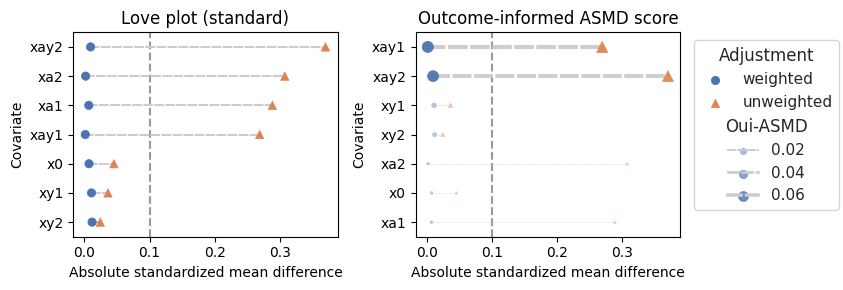

In [15]:
fig = mpl.figure.Figure(figsize=(7, 3))
axes = fig.subplot_mosaic("AE", sharex=True)
fig, axes = mpl.pyplot.subplot_mosaic("AE", figsize=(7, 3), sharex=True, sharey=False)
p = ouilove_plot(
    ouiasmd, 
    plot_range=True,
    order_by_importance=False,
    opacity=False,
    pointsize=False,
    legend=False,
    threshold=0.1, ax=axes["A"],
)
axes["A"].set_title("Love plot (standard)")

p = ouilove_plot(
    ouiasmd, 
    plot_range=True,
    order_by_importance=True,
    opacity=True,
    pointsize=True,
    importance_metric="Oui-ASMD",
    legend=True,
    threshold=0.1, ax=axes["E"],
)
axes["E"].set_title("Outcome-informed ASMD score")
fig.tight_layout()

In [16]:
covariate_obfuscation = {
    c: str(l) for c, l in zip(
        np.random.default_rng(1).permutation(ouiasmd["covariate"].unique()),
        range(ouiasmd["covariate"].nunique())
    )
}
ouiasmd = ouiasmd.replace({
    "covariate": covariate_obfuscation,
})

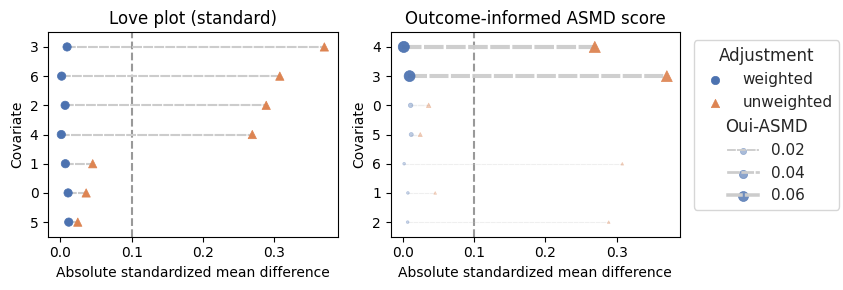

In [17]:
fig = mpl.figure.Figure(figsize=(7, 3))
axes = fig.subplot_mosaic("AE", sharex=True)
fig, axes = mpl.pyplot.subplot_mosaic("AE", figsize=(7, 3), sharex=True, sharey=False)
p = ouilove_plot(
    ouiasmd, 
    plot_range=True,
    order_by_importance=False,
    opacity=False,
    pointsize=False,
    legend=False,
    threshold=0.1, ax=axes["A"],
)
axes["A"].set_title("Love plot (standard)")

p = ouilove_plot(
    ouiasmd, 
    plot_range=True,
    order_by_importance=True,
    opacity=True,
    pointsize=True,
    importance_metric="Oui-ASMD",
    legend=True,
    threshold=0.1, ax=axes["E"],
)
axes["E"].set_title("Outcome-informed ASMD score")
fig.tight_layout()

## Main part
 * how much do you agree with the problem (Setting/setup)
 * how much do you agree with the need for a solution
 * how much did the visualization improve your interpretation. 
 [also allow for additional free-text comments on each]

### Participant details

* Principle role / background (school of causality)
* experience in causality years
* familiarity with Matching / IPW
* experience in reading/interpreting Love plots [years]   ?   # really break it down to reading/generating?
* experience in generating Love plots [years] ?
* continent of primary work


## Ablation
Compare against standard Love plot:
 * size
 * opacity
 * order
 * (size, opacity)
 * (size, opacity, order)
 [score each 0-10] [‘Less useful’, ‘Equal/no preference’, ‘A bit more useful’, ‘Somewhat more useful’ and ‘Much more useful’]
 [Then rank]
 [free text comments]